In [2]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

In [2]:
from subprocess import check_output
print(check_output(["ls", "../sign_data"]).decode("utf8"))

full



In [3]:
def show_image(image,text=None, should_save=False):
    np_image = image.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()    

In [4]:
# ####### THIS IS FOR CREATING THE DATASET, DONT RUN IT BECAUSE I HAVE CREATED IT ALREADY AND YOU WILL MESS IT UP

# # Define the base path for signature images
# file_path = '../sign_data/full'

# # Initialize an empty list to store the data
# data_list = []

# # List and sort the folders, then select the first 128 folders
# folders = sorted(os.listdir(file_path))[:128]

# for i in range(0, len(folders), 2):  # Process every second folder
#     genuine_folder = folders[i]
#     genuine_path = os.path.join(file_path, genuine_folder)
#     forgery_path = os.path.join(file_path, genuine_folder + '_forg')
    
#     # Generate all pairs of genuine signatures
#     genuine_files = os.listdir(genuine_path)
#     for y in genuine_files:
#         for z in genuine_files:
#             if y != z:
#                 data_list.append([os.path.join(genuine_folder, y), os.path.join(genuine_folder, z), 1])
                
#     # Generate pairs of genuine and forged signatures
#     if os.path.exists(forgery_path):  # Check if the forgery folder exists
#         forged_files = os.listdir(forgery_path)
#         for y in genuine_files:
#             for z in forged_files:
#                 data_list.append([os.path.join(genuine_folder, y), os.path.join(genuine_folder + '_forg', z), 0])

# # Create a DataFrame from the list
# data = pd.DataFrame(data_list, columns=['image1', 'image2', 'label'])

# # Save the DataFrame to a CSV file
# #data.to_csv('saved_data.csv', index=False)


In [5]:
# data = pd.read_csv('saved_data.csv').sample(frac=1) 

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     data.iloc[:, :2],  # Selects the first two columns as features
#     data.iloc[:, 2],   # Selects the third column as the target variable
#     test_size=0.2,     # Allocates 10% of the data for the test set
#     stratify=data.iloc[:, 2]  # Ensures the training and testing sets have similar target variable distribution
# )

In [6]:
#pd.concat([X_train,y_train],axis=1).to_csv('train_data.csv',index=False)
#pd.concat([X_test,y_test],axis=1).to_csv('test_data.csv',index=False)

In [7]:
data_directory = "../sign_data/full"
train_csv = "train_data.csv"
test_csv = "test_data.csv"

In [8]:
from dataset import Create_Dataset
dataset = Create_Dataset(train_csv, data_directory, transform=transforms.Compose([transforms.Resize((105,105)), transforms.ToTensor()]))

torch.Size([1, 1, 105, 105])


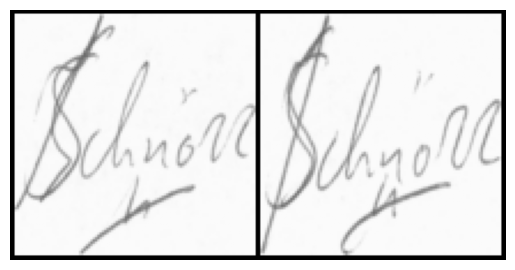

[[1.]]


In [9]:
visual_loader = DataLoader(dataset, shuffle=True, batch_size=1)
data_iterator = iter(visual_loader)


example_batch = next(data_iterator)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
print(example_batch[0].size())
show_image(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# 0 - forged, 1 - genuine

In [21]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [22]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Args:
            output1 (tensor): output vectors of the first set of samples
            output2 (tensor): output vectors of the second set of samples
            label (tensor): 1D tensor of 0s and 1s where 1 means the sample pairs are similar and
                            0 means the sample pairs are dissimilar.
        """
        # Calculate the Euclidean distance between the two outputs
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Similar pairs: Calculate the loss as the square of the euclidean distance
        loss_similar = label * torch.pow(euclidean_distance, 2)

        # Dissimilar pairs: Calculate the loss as the square of the margin minus the euclidean distance
        # Clipped at zero if the distance is greater than the margin
        loss_dissimilar = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)

        # Average loss over the batch
        loss = torch.mean(loss_similar + loss_dissimilar)

        return loss

In [23]:
training_set = DataLoader(dataset, shuffle=True, num_workers=8, batch_size=64)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [25]:
# Initialize the network and move it to the appropriate device
neural_network = SiameseNetwork().to(device)

# Setup the criterion for contrastive loss and the optimizer
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(neural_network.parameters(), lr=0.0001)

# Define the number of epochs for training
number_of_epochs = 200

In [26]:
def train(training_set):
    counter = []
    loss_history = [] 
    iteration_number = 0
    
    for epoch in range(number_of_epochs):
        for i, data in enumerate(training_set, 0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2 = neural_network(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

    return neural_network